Лабораторная работа №3
=====
Решение задач комбинаторной оптимизации на примере задачи коммивояжера с помощью генетического алгоритма
=====

## Цель задания
Знакомство с базовыми задачами комбинаторной оптимизации, их постановками и особенностями решения с помощью ГА. Изучение метода решения задачи коммивояжера с помощью ГА. Изучение основных способов представления особей-туров и основных операторов рекомбинации для каждого представления. Реализация генетического алгоритма, решающего задачу коммивояжера.
## Постановка задачи
Дано множество городов, заданных координатами (xi,yi) на плоскости. Стоимость перехода от одного города к другому определяется евклидовым расстоянием между ними. Решить задачу коммивояжера, т.е. построить тур обхода всех городов минимальной стоимости, с помощью генетического алгоритма. При решении использовать представление путей, оператор кроссинговера и тестовый пример, указанный в варианте. Иллюстрировать графически поиск оптимального тура.
## Вариант 2
Упорядоченный ОК (ОХ), файл eil51.tsp.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

#### Фукция расчета фитнесса

In [10]:
def distance(a , b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

In [11]:
def fitness(route, coords):
    sum = 0
    for i in range(1, len(route)):
        sum += distance(coords[route[i - 1]], coords[route[i]])

    sum += distance(coords[route[-1]], coords[route[0]])
    return sum

In [12]:
def fitness_all(population, coords):
    result = []
    for p in population:
        result.append(fitness(p, coords))

    return np.array(result)

#### Функция создания начальной популяции.

In [2]:
def create_population(size, num_points):
    return [random.sample(range(num_points), num_points) for i in range(size)]

#### Реализация функции турнирной селекции

In [3]:
def tournament_selection(population, fitness, m):
    size = len(population)
    f_vals = np.array(fitness(population))
    new_population = []
    for i in range(size):
        idx = np.random.randint(0, size, m)
        id = idx[np.argmin(f_vals[idx])]
        new_population.append(population[id])

    return new_population

#### Реализация функции упорядоченного кроссинговера

In [4]:
def crossing_over(a, b):
    n = len(a)
    l = np.random.randint(0, n, 1)[0]
    r = np.random.randint(0, n, 1)[0]
    if l > r:
        tmp = l
        l = r
        r = tmp

    br = np.roll(b, n-r)
    idx = np.argwhere(np.isin(br, np.array(a)[l:r]))
    br = np.delete(br, idx)
    child1 = np.concatenate((np.array(a)[l:r], br))
    child1 = np.roll(child1, l)
    ar = np.roll(a, n - r)
    idx = np.argwhere(np.isin(ar, np.array(b)[l:r]))
    ar = np.delete(ar, idx)
    child2 = np.concatenate((np.array(b)[l:r], ar))
    child2 = np.roll(child2, l)
    return child1, child2

In [5]:
def make_children(population, pc=0.5):
    recombined = []
    size = len(population)
    for p in population:
        if np.random.random_sample(1)[0] > pc:
            continue

        i = np.random.randint(0, size, 1)[0]
        ch1, ch2 = crossing_over(p, population[i])
        recombined.append(ch1)
        recombined.append(ch2)

    return recombined

#### Реализация функции мутации

In [6]:
def mutation(population, mp=0.1):
    num_genes = len(population[0])
    for p in population:
        if np.random.random_sample(1)[0] > mp:
            continue

        idx = np.random.randint(0, num_genes, 2)
        p[idx[0]], p[idx[1]] = p[idx[1]], p[idx[0]]

    return population

#### Реализация функции находящей минимум с помощью генетического алгоритма.

In [7]:
def reduction(population, fitness, size):
    f_vals = fitness(population)
    idx = f_vals.argsort()
    new_population = []
    for i in range(size):
        new_population.append(population[idx[i]])

    return new_population

In [8]:
def run_ga(f, size, num_genes, cop, mp, num_iterations=10):
    p = create_population(size, num_genes)
    fitness = f(p)
    populations = [p]
    populations_min = [(np.min(fitness), p[fitness.argmin()])]
    populations_mean = [np.mean(fitness)]
    for i in range(num_iterations):
        parents = tournament_selection(p, f, m=5)
        offsprings = make_children(parents, pc=cop)
        offsprings = mutation(offsprings, mp)
        p = reduction(p + offsprings, f, size)
        populations.append(p)
        fitness = f(p)
        populations_min.append((np.min(fitness), p[fitness.argmin()]))
        populations_mean.append(np.mean(fitness))

    return populations, populations_min, populations_mean

#### Вспомогательные функции

In [9]:
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.read().split('\n')
        i = 6
        coords = []
        while lines[i] != 'EOF':
            nums = lines[i].split(' ')
            coords.append([int(nums[1]), int(nums[2])])
            i += 1

        return coords

In [13]:
def plot_graph(points, coords):
    coords = np.array(coords)
    x1 = coords[points, 0]
    x2 = coords[points, 1]
    plt.figure(figsize=(12, 8))
    plt.plot(x1, x2, linestyle='dashed', marker='o', markerfacecolor='blue', markersize=12)
    for i, p in enumerate(zip(x1, x2)):
        plt.text(p[0]+0.5, p[1]+0.5, str(i+1), color="red", fontsize=12)

    plt.show()

In [14]:
def info(epoch, f_value, route, coords):
    print(f'Epoch {epoch} fitness: {f_value}')
    print(f'Route: {route}')
    plot_graph(route, coords)

#### Зададим основные параметры алгоритма

In [15]:
coords = read_data('eil51.tsp')

In [20]:
num_points = len(coords)
population_size = 10
crossing_over_probability = 0.5
mutation_probability = 0.1
num_epoch = 50
f = lambda p: fitness_all(p, coords)

#### Поиск оптимального пути

In [21]:
populations, mins, means = run_ga(f, population_size, num_points, crossing_over_probability, mutation_probability, num_epoch)
print(f'Resulting fitness: {mins[-1][0]}')
print(f'Optimal route: {mins[-1][1]}')

Resulting fitness: 1136.538691091532
Optimal route: [46 12 16 26 31 36 43  8 45 50 13  6 38 29  9  3 21 19 33 15  0 47 22  5
 25  1 49 37 28 32 44 41  2 27 14 20 40 39 18 23 24 42 30  7 34 35  4 11
 48 10 17]


Epoch 0 fitness: 1539.7252690814648
Route: [44, 12, 48, 1, 36, 45, 23, 46, 31, 43, 7, 5, 50, 13, 6, 9, 21, 15, 33, 19, 0, 47, 22, 10, 39, 16, 37, 26, 49, 25, 28, 32, 41, 2, 27, 14, 20, 40, 17, 18, 29, 24, 42, 3, 30, 8, 34, 35, 38, 4, 11]


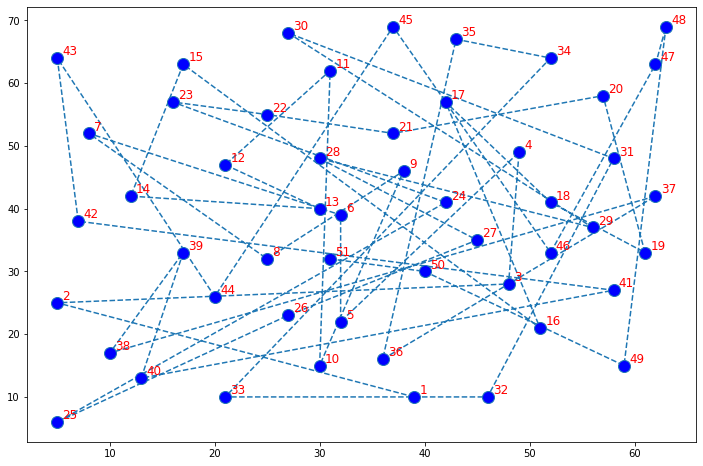

In [22]:
info(0, mins[0][0], mins[0][1], coords)

Epoch 10 fitness: 1490.1597030540615
Route: [44 12 48 36 45 23 46 26 31 43  7  5 50 13  6  9 21 15 33 19  0 47 22 10
 39 16 37  1 49 25 28 32 41  2 27 14 20 40 17 18 29 24 42  3 30  8 34 35
 38  4 11]


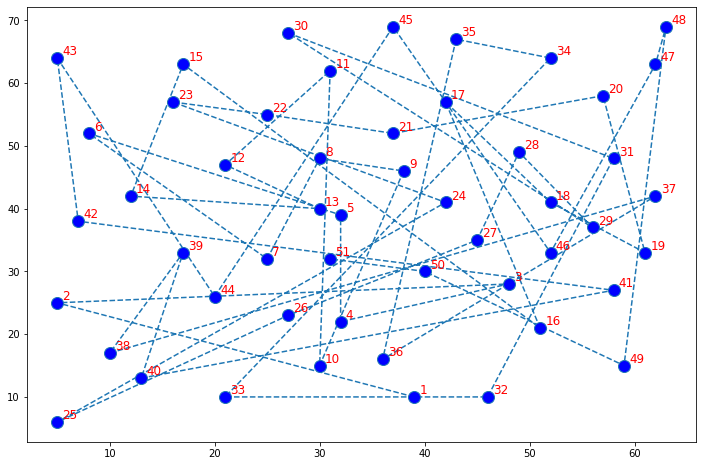

In [23]:
info(10, mins[10][0], mins[10][1], coords)

Epoch 20 fitness: 1440.7025066503882
Route: [12 48 10  5 23 46 26 31 43  7 45 50 13  6  9  3 21 15 33 19  0 47 22 36
 39 16 37  1 49 25 28 32 41  2 27 14 20 40 17 18 29 24 42 30  8 34 35 38
  4 11 44]


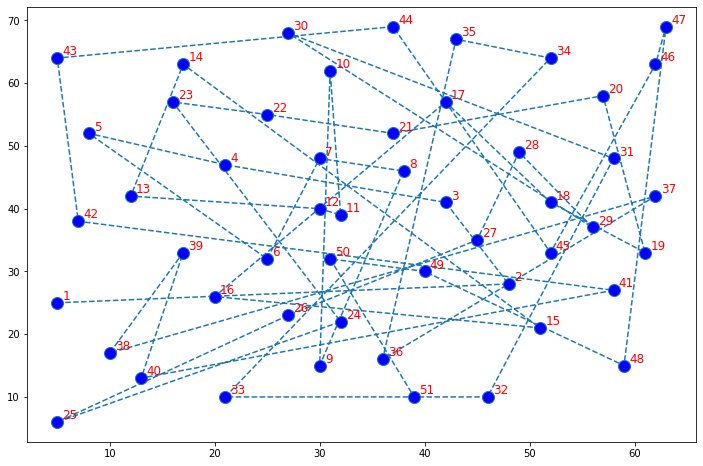

In [24]:
info(20, mins[20][0], mins[20][1], coords)

Epoch 30 fitness: 1251.43811606117
Route: [46 12 16 26 31 43 36  7 45 50 13  6 38 29  9  3 21 15 33 19  0 47 22 17
 37  1 49 25 28 32 44 41  2 27 14 20 40 39 18 23 24 42 30  8 34 35  4 11
 48 10  5]


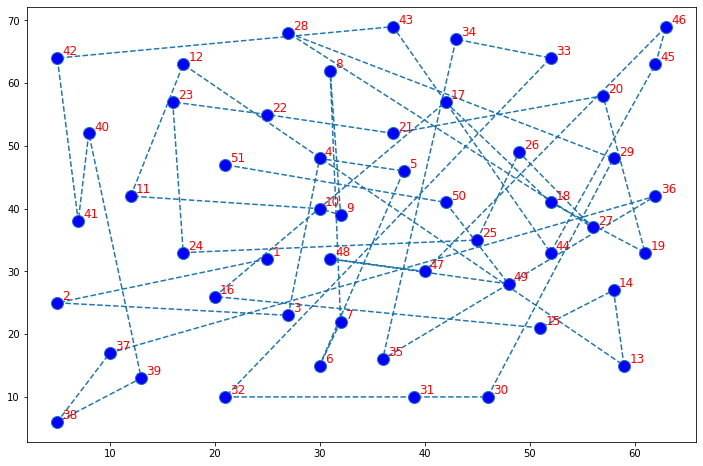

In [25]:
info(30, mins[30][0], mins[30][1], coords)

Epoch 50 fitness: 1136.538691091532
Route: [46 12 16 26 31 36 43  8 45 50 13  6 38 29  9  3 21 19 33 15  0 47 22  5
 25  1 49 37 28 32 44 41  2 27 14 20 40 39 18 23 24 42 30  7 34 35  4 11
 48 10 17]


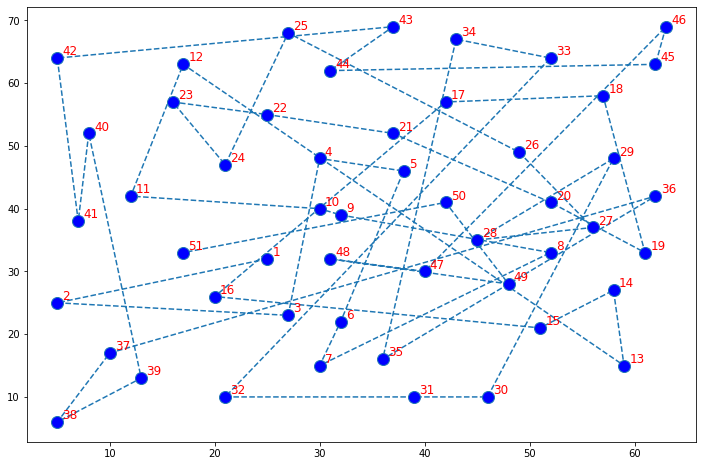

In [26]:
info(50, mins[-1][0], mins[-1][1], coords)

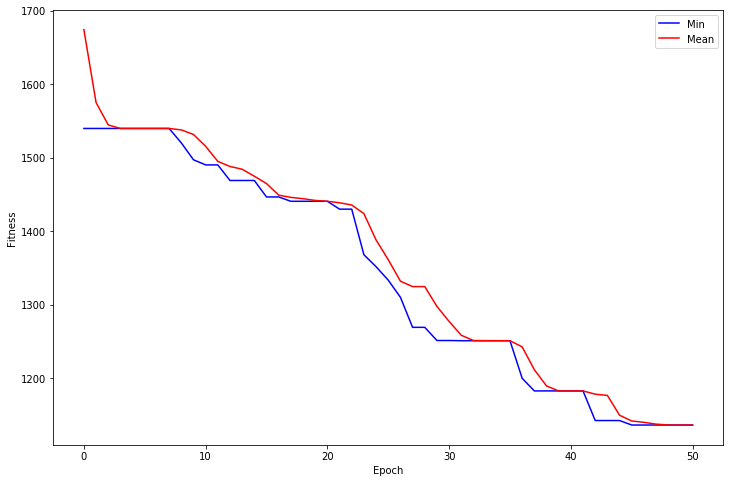

In [27]:
plt.figure(figsize=(12, 8))
min_vals = [m[0] for m in mins]
plt.plot(range(num_epoch+1), min_vals, c='b')
plt.plot(range(num_epoch+1), means, c='r')
plt.xlabel('Epoch')
plt.ylabel('Fitness')
plt.legend(['Min', 'Mean'])
plt.show()

## Вывод
В данной лабораторной работе реализован алгоритм нахождения приближенного решения задачи коммивояжера. Решение использует геном в виде представления путей, тип кроссинговера - упорядоченный ОК, турнирный отбор, элитарную схему сокращения популяции.